# [NTDS'18] milestone 4: graph signal processing
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: `01`
* Students: `Yassine Zouaghi, Timothée Bornet dit Vorgeat, Pol Boudou, Icíar Lloréns Jover`
* Dataset: `IMDb Films and Crew`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to do some Graph Signal Processing (GSP) on the data of your project.

### A note about plotting

There are several questions in this milestone that ask you to plot a signal on your network.
There are several ways from which you could approach it.
In all cases, compute the position of the nodes a single time at the beginning, as this is likely to be a costly operation.
Using a single layout for all the graph plots will also make it easier to compare the plots.
Indeed, the only thing changing between plots is the signal displayed.
You can represent the features/labels lying on the graph via node **colors**.
To do so, make sure to have a consistent color map throughout and remember to display a colorbar and scale in all plots, so that we can tell what numbers the colors represent.

* An option is to use the **Laplacian eigenmaps** that you have seen in the previous milestone to embed your graph on the plane. For example:
  ```
  from matplotlib import pyplot as plt
  plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=signal, alpha=0.5)
  plt.colorbar()
  ```
* Another option is to use the plotting capabilities of **[NetworkX](https://networkx.github.io)**.
  See the documentation of its [drawing methods](https://networkx.github.io/documentation/stable/reference/drawing.html).
  For example:
  ```
  import networkx as nx
  graph = nx.from_scipy_sparse_matrix(adjacency)
  coords = nx.spring_layout(graph)  # Force-directed layout.
  coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
  nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal)
  nx.draw_networkx_edges(graph, coords, alpha=0.3)
  ```
* Another option is to use the plotting capabilities of the **[PyGSP](https://github.com/epfl-lts2/pygsp)**, a Python package for Graph Signal Processing.
  **Note that your are forbidden to use the PyGSP for anything else than plotting.**
  See the documentation of its [plotting utilities](https://pygsp.readthedocs.io/en/stable/reference/plotting.html).
  For example:
  ```
  import pygsp as pg
  graph = pg.graphs.Graph(adjacency)
  graph.set_coordinates('spring')  # Force-directed layout.
  graph.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
  graph.plot_signal(signal)
  ```
* Yet another option is to save your graph on disk, use **[Gephi](https://gephi.org)** externally, to visualize the graph, save the graph with the Gephi coordinates and finally load the nodes coordinates back into the notebook.

We encourage you to try all the above methods before making your choice. Then be consistent and use only one throughout the milestone.
NetworkX and PyGSP should already be installed in your environement. If that's not the case, install with `conda install networkx pygsp` (after activating the `ntds_2018` environment).

## 0 - Load your network

In [14]:
%matplotlib inline

If you get a `No module named 'pyunlocbox'` error when running the below cell, install the [pyunlocbox](https://github.com/epfl-lts2/pyunlocbox) with `conda install pyunlocbox` (after activating the `ntds_2018` environment).

In [15]:
import numpy as np
from scipy import sparse
from scipy.sparse import csgraph
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pandas as pd

import networkx as nx

For this milestone, all we will need is a set of features/labels for each of the nodes on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.

Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).

_Note_: If your features/labels are not floating-point numbers, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".  

In [16]:
DATA_PATH = "DataMS1/"

**1. Load the adjacency matrix**

In [17]:
biggest_adjacency = np.load(DATA_PATH + 'biggest_adjacency.npy')

degree_weighted_imdb = biggest_adjacency.sum(1)
D = np.diag(degree_weighted_imdb)

**2. Extract the labels**

In [18]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    # Convert adjacency matrix into an adjacency list
    # This makes it easier to navigate through the nodes
    adj_list = []
    for i in range(0, len(adjacency)):
        adj_list.append(list(np.nonzero(adjacency[i])[0]))
        
    # Each node will be assigned a label (starting from 1) according 
    # to which connected component it belongs. If the label is 0, 
    # it means it has not been visited yet.
    nodes = np.zeros(len(adjacency))
    # n counts the number of connected components
    n = 0
    
    while (np.count_nonzero(nodes) != len(adjacency)):
        n = n+1
        # We start from the first node that has not been visited
        start = np.where(nodes == 0)[0][0]
        queue = []
        visited = set()

        queue.append(start)
        visited.add(start)

        while queue:
            current = queue.pop(0)
            for node in adj_list[current]:
                if node not in visited:
                    queue.append(node)
                    visited.add(node)
        
        visited = list(visited)
        # Visited nodes are assigned their label
        nodes[visited] = n
        
    return nodes

Here, we extract the labels from our features. the labels are the genres. However, since our graph is not connected and we are only taking the nodes from the biggest connected component, we need to find out which nodes belong to that component so as to take only the labels assigned to them. 

In [19]:
adjacency =  np.load(DATA_PATH + 'adjacency.npy')
features = pd.read_csv(DATA_PATH + 'features.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

# Find the nodes from the biggest connected component and select the features assigned to those nodes
nodes = find_components(adjacency)
idx = [i for i in range(len(nodes)) if nodes[i] == 1]
features = features.iloc[idx]

# Each node's labels is initially the list of genres associated to it. When the genre is empty for a 
# node, we set it to Other.
genres = features.genres
labels = genres.apply(lambda x: list(pd.read_json(x, dtype=False).name) if x != '[]' else ['Other'])
labels = labels.apply(lambda x: ", ".join(x))

# Finally, we create a dataframe 
labels_df = pd.DataFrame(labels.reset_index(drop=True))
labels_df.head()

,genres
0,"Action, Adventure, Fantasy, Science Fiction"
1,"Adventure, Fantasy, Action"
2,"Action, Adventure, Crime"
3,"Action, Crime, Drama, Thriller"
4,"Action, Adventure, Science Fiction"


Now that we have a dataframe with each node index containing a list of genres, we use a one hot encoding to transform the labels.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
def getCatFeatures(df, Col):
    vectorizer = CountVectorizer(binary=True,
                                 ngram_range=(1,1),
                                 tokenizer=lambda x:[a.strip() for a in x.split(',')])
    return (vectorizer.fit_transform(df[Col]), vectorizer.vocabulary_)
Sparse_labels, vocab_labels = getCatFeatures(labels_df,'genres')

Finally, we need a binary label signal. We achieve this by taking only one genre. This way, if a movie belongs to the genre, its label is 1, otherwise its label is 0. We decided to use 'Action' as a determining genre.

In [260]:
labels_oh = pd.SparseDataFrame([pd.SparseSeries(Sparse_labels[i].toarray().ravel()) for i in np.arange(Sparse_labels.shape[0])],
                               columns = sorted(list(vocab_labels)))
label_signal = np.array(labels_oh.action)

**3. Number of nodes and laplacian**

In [340]:
n_nodes =  len(biggest_adjacency)
laplacian = sparse.csgraph.laplacian(biggest_adjacency, normed=True)

**4. Gradient**

We have used a combinatorial Laplacian. In order to compute the Gradient matrix, we cannot use the incidence matrix anymore because our graph is weighted. Given the number of nodes $N$ and the number of edges $E$, 

- for each edge the gradient is $\nabla f [i,j] = \sqrt{w_{ij}}(f(j)-f(i))$.
- the gradient matrix is of size $E\times N$.

In [10]:
N = n_nodes  # number of nodes
E = np.sum(biggest_adjacency > 0)  # number of edges (non-zero entries of A)
gradient = np.zeros((E, N))
eij = 0  # edge index
for i in range(N):
    for j in range(N):
        wij = biggest_adjacency[i, j]
        if wij > 0:
            gradient[eij, i] = - np.sqrt(wij) 
            gradient[eij, j] = np.sqrt(wij)
            eij = eij + 1  # increment the edge index

In [11]:
print("Number of edges: {}, number of nodes: {} \nGradient shape: {}".format(E, N, gradient.shape))

Number of edges: 310938, number of nodes: 4615 
Gradient shape: (310938, 4615)


Convert our gradient to a sparse matrix.

In [12]:
gradient = sparse.csr_matrix(gradient)

## 1 - Graph Fourier Transform

In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.

### Question 1

Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.

In [341]:
# We compute ordered eigenvalues e and graph Fourier basis U with eigh
e , U = scipy.linalg.eigh(laplacian)

Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.

In [342]:
# Graph creation
graph = nx.from_scipy_sparse_matrix(sparse.csr_matrix(biggest_adjacency))
coords = U[:,1:3]  # Laplacian eigenmaps

/home/pol/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


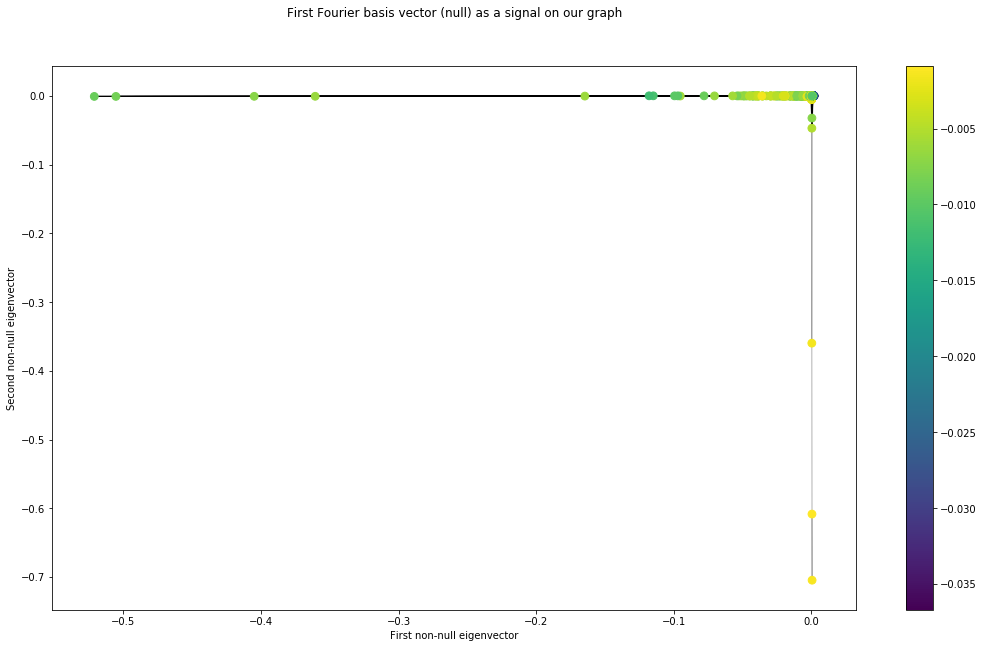

In [219]:
plt.figure(figsize = (18,10))
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=U[:,0])
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("First Fourier basis vector (null) as a signal on our graph", y=1.08)
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes)
plt.show()

/home/pol/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


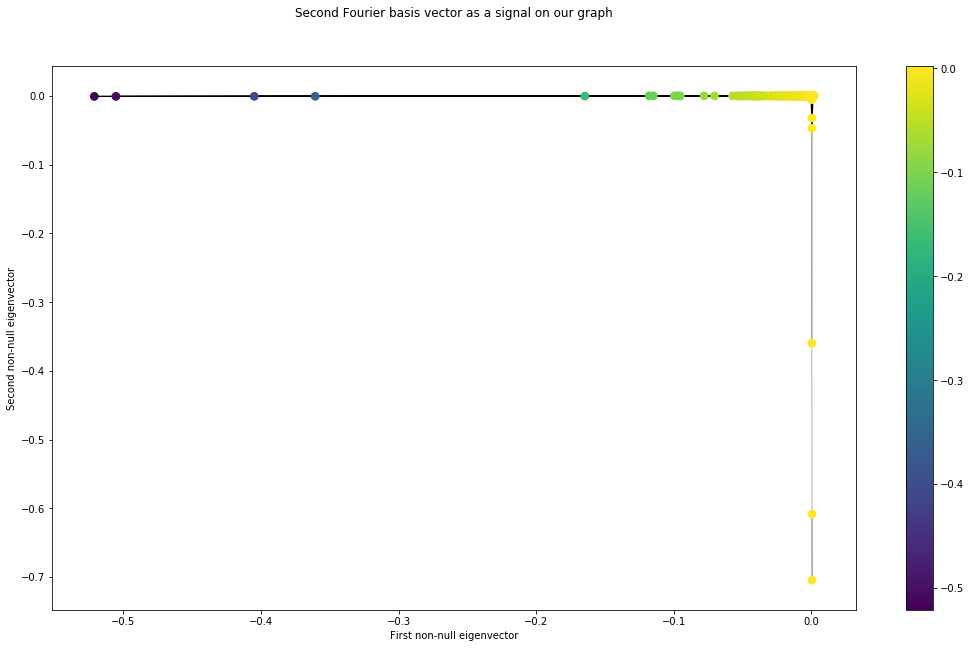

In [220]:
plt.figure(figsize = (18,10))
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=U[:,1])
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Second Fourier basis vector as a signal on our graph", y=1.08)
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes)
plt.show()

/home/pol/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


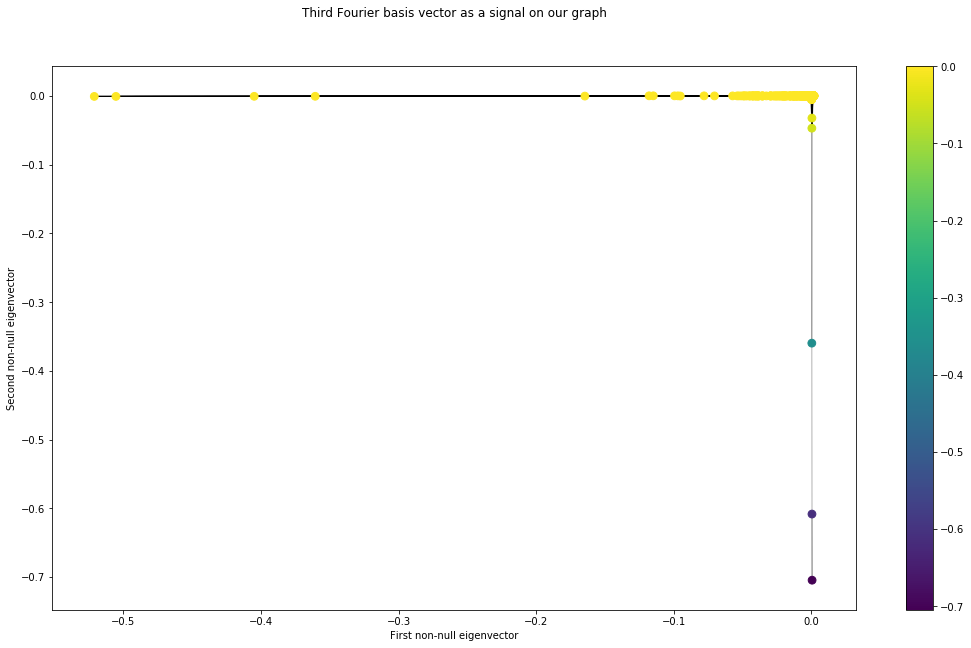

In [221]:
plt.figure(figsize = (18,10))
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=U[:,2])
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Third Fourier basis vector as a signal on our graph", y=1.08)
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes)
plt.show()

/home/pol/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


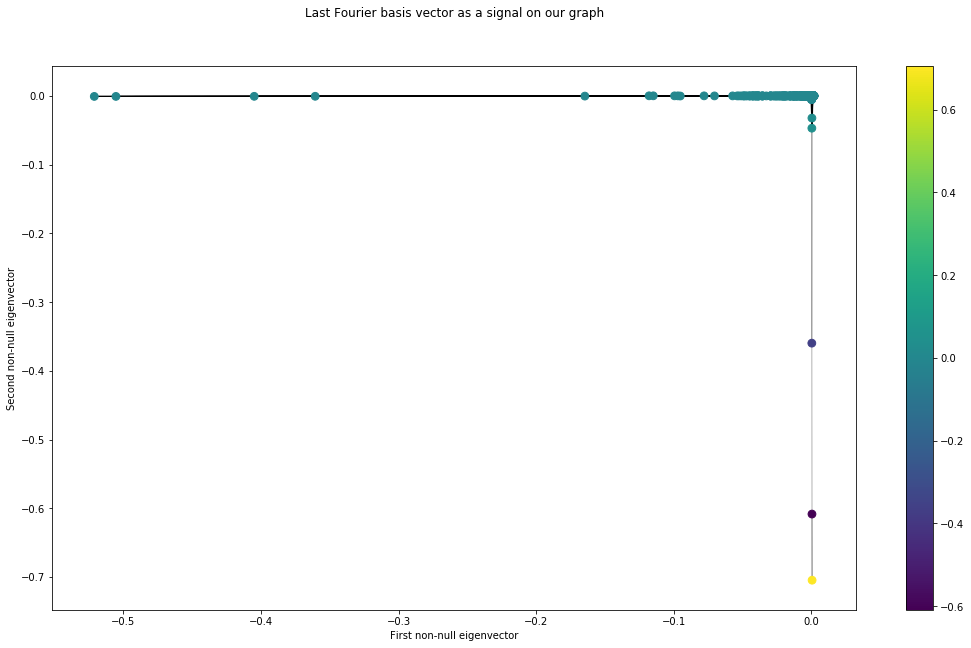

In [222]:
plt.figure(figsize = (18,10))
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=U[:,-1])
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Last Fourier basis vector as a signal on our graph", y=1.08)
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes)
plt.show()

### Question 2

What can you observe in terms of local variations when comparing the basis vectors corresponding to the smallest eigenvalues to those corresponding to the largest eigenvalue? How would this justify the interpretation of the eigenvalues as "graph frequencies"?

**Your answer here.**

**As our graph (biggest component only) is composed of a cluster and a few outliers, the information presented by an individual graph alone does not offer much information about the nodes in the cluster (high-degree nodes).**

The first Fourier basis vector (associated to eigenvalue 0) present small but observable variations (very tight color range) . Similarly, second and third eigenvectors present significantly bigger variations . Finally, the last Fourier basis vector present the biggest variations (from -0.6 to 0.6). In fact, we say that the eigenvalues for  which  the  corresponding  proper  eigenvectors  have  small variations are labeled as low frequencies and vice-versa.

### Question 3

Implement a function that returns the Graph Fourier Transform (GFT) of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).

In [446]:
def GFT(x):
    return np.matmul(U.T, x);

def iGFT(x):
    return np.matmul(U, x);

### Question 4

Plot your feature/label vector as a signal on your graph

/home/pol/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


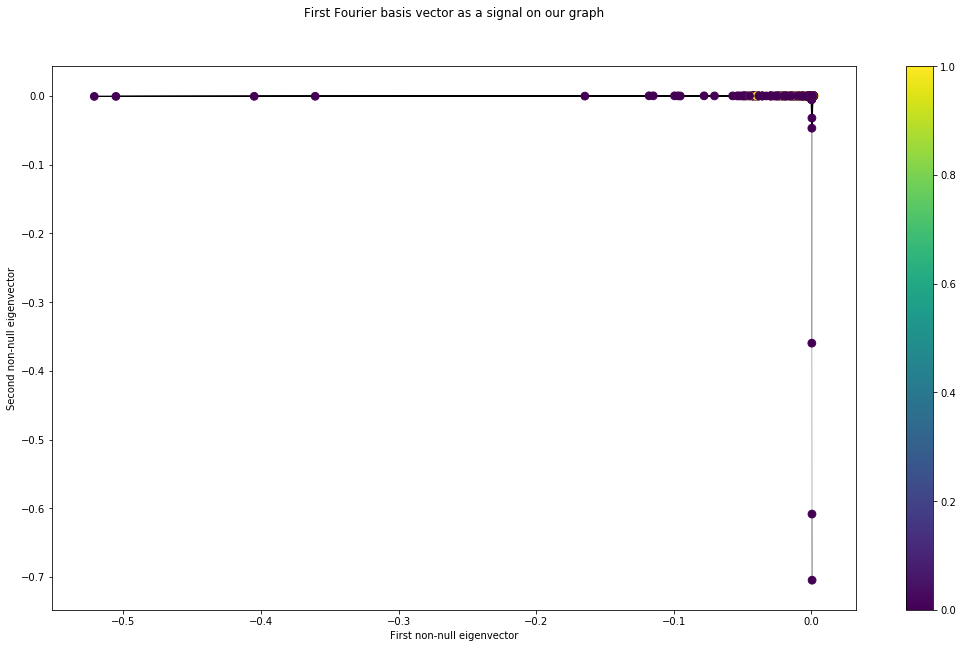

In [230]:
plt.figure(figsize = (18,10))
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=label_signal)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("First Fourier basis vector as a signal on our graph", y=1.08)
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes)
plt.show()

**As our label signal is 1 if the movie is labeled "Action" and 0 else, most of the nodes in our graph are labeled "0" (represented in dark blue)**

Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

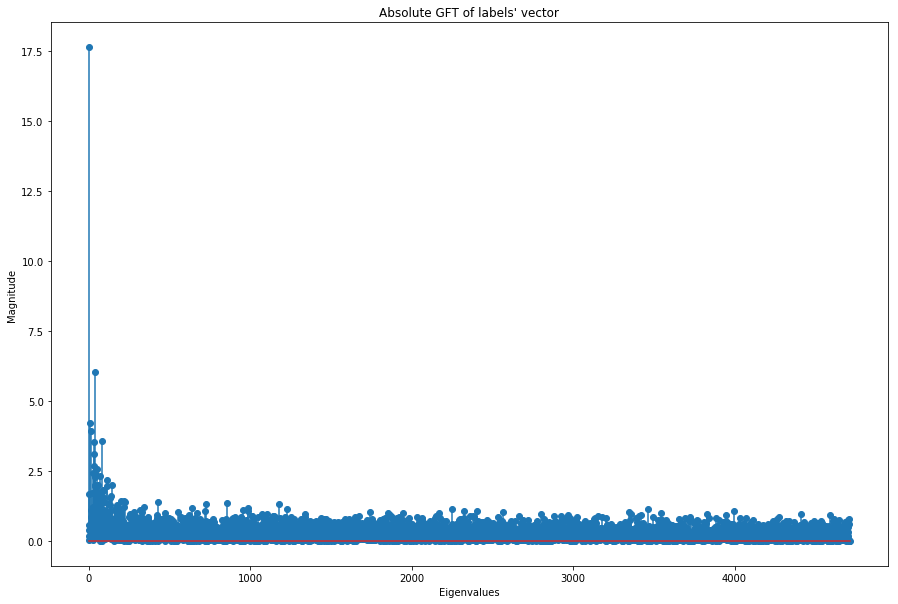

In [344]:
# Your code here.
absolute_GFT_labels = np.abs(GFT(label_signal))
plt.figure(figsize = (15,10))
plt.stem(absolute_GFT_labels)
plt.title("Absolute GFT of labels' vector")
plt.xlabel("Eigenvalues")
plt.ylabel("Magnitude")
plt.show()

### Question 5

Discuss the behavior of the GFT that you plotted in the last question via comparing the plot of your label signal and those of the Fourier basis of Question 1. Would you consider your labels a "low-pass" or "high-pass" signal, or yet something else entirely?

**Your answer here.**

**Looking at the GFT of our labels vector in the spectral domain, we clearly see that it acts as a low pass filter.** 

## 2 - Filtering on graphs

In this section we will check how filtered Dirac impulses diffuse on your graph.

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

In [442]:
def heat_kernel(eig, tau):
    return np.exp(eig * (tau))

def inverse_kernel(eig, tau):  
    return 1./(np.ones(eig.shape) + tau * eig)

def rectangle_kernel(eig, l_min, l_max):
    rect = eig.copy()
    rect[np.where(rect > l_max)] = 0
    rect[np.where(rect < l_min)] = 0
    rect[rect > 0] = 1
    return rect

def graph_filter(x, kernel, **kwargs):
    GFT_x = GFT(x)
    filtered_x = np.matmul(np.diag(kernel(GFT_x.copy(), **kwargs)),GFT_x)
    return iGFT(filtered_x)

### Question 7

Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

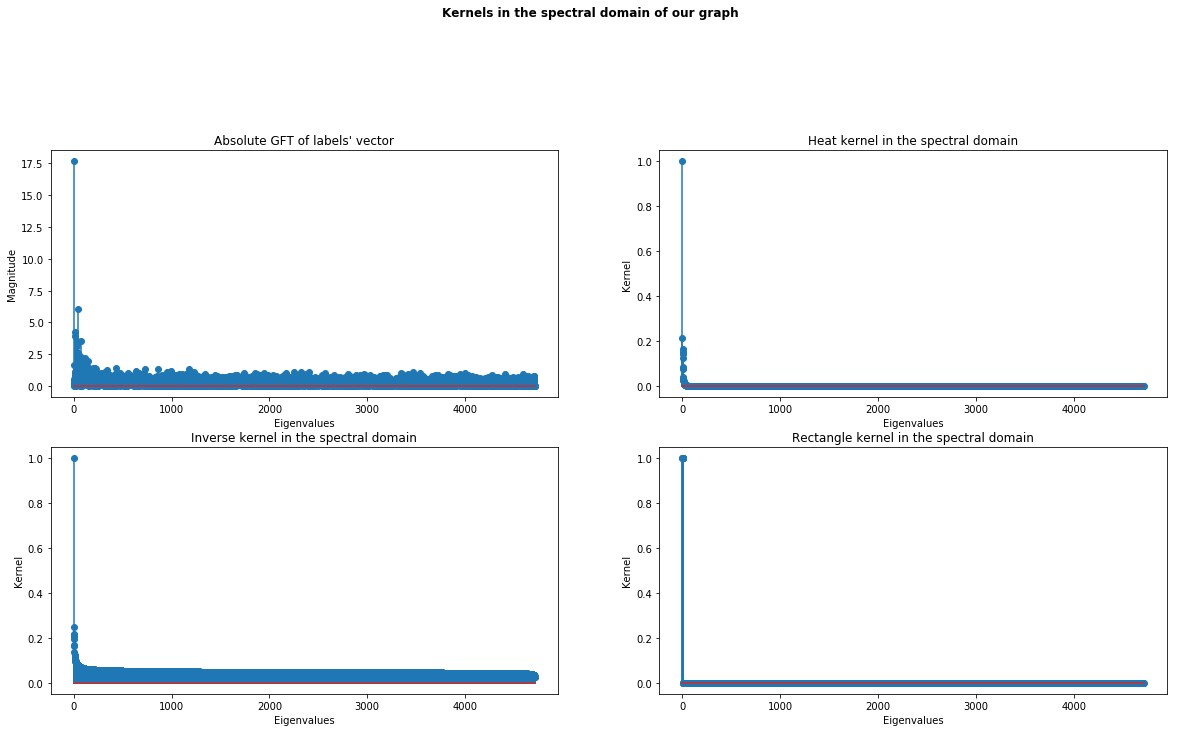

In [379]:
f, ([original, ax1], [ax2, ax3]) = plt.subplots(2, 2, figsize=(20, 10))
f.suptitle("Kernels in the spectral domain of our graph", y=1.08, fontweight="bold")

original.stem(absolute_GFT_labels)
original.set_title("Absolute GFT of labels' vector")
original.set_xlabel("Eigenvalues")
original.set_ylabel("Magnitude")

ax1.stem(heat_kernel(e, -10))
ax1.set_title("Heat kernel in the spectral domain")
ax1.set_xlabel("Eigenvalues")
ax1.set_ylabel("Kernel")

ax2.stem(inverse_kernel(e, 20))
ax2.set_title("Inverse kernel in the spectral domain")
ax2.set_xlabel("Eigenvalues")
ax2.set_ylabel("Kernel")

ax3.stem(rectangle_kernel(e, 0,0.3))
ax3.set_title("Rectangle kernel in the spectral domain")
ax3.set_xlabel("Eigenvalues")
ax3.set_ylabel("Kernel")

plt.show()

### Question 8

Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.

**As we already know, our graph is composed of very few low-degree nodes. This makes our graph visualisations not very significant. For this question, we specifically choose Diracs on those low-degree nodes in order to observe some results.**

In [345]:
#We find outliers nodes in our graph
degrees = np.asarray([val for (node, val) in graph.degree()])
np.where( degrees == 1)

(array([1289, 2286, 2678, 3188, 3218, 3399, 3622, 3668, 3706, 3869, 3894,
        3999, 4054, 4097, 4111, 4193, 4217, 4285, 4287, 4302, 4307, 4321,
        4333, 4360, 4379, 4423, 4437, 4449, 4468, 4477, 4519, 4522, 4530,
        4565, 4575, 4664, 4682, 4696]),)

In [346]:
#We define two diracs on nodes 110 and 3050 of our graph
dirac = np.zeros(n_nodes)
dirac[2678] = 1
dirac[3188] = 1

In [347]:
heat_filtered_dirac = graph_filter(dirac, heat_kernel, tau=-0.2)
inverse_filtered_dirac = graph_filter(dirac, inverse_kernel, tau=2)
rectangle_filtered_dirac = graph_filter(dirac, rectangle_kernel, l_min=0, l_max=0.5)

/home/pol/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


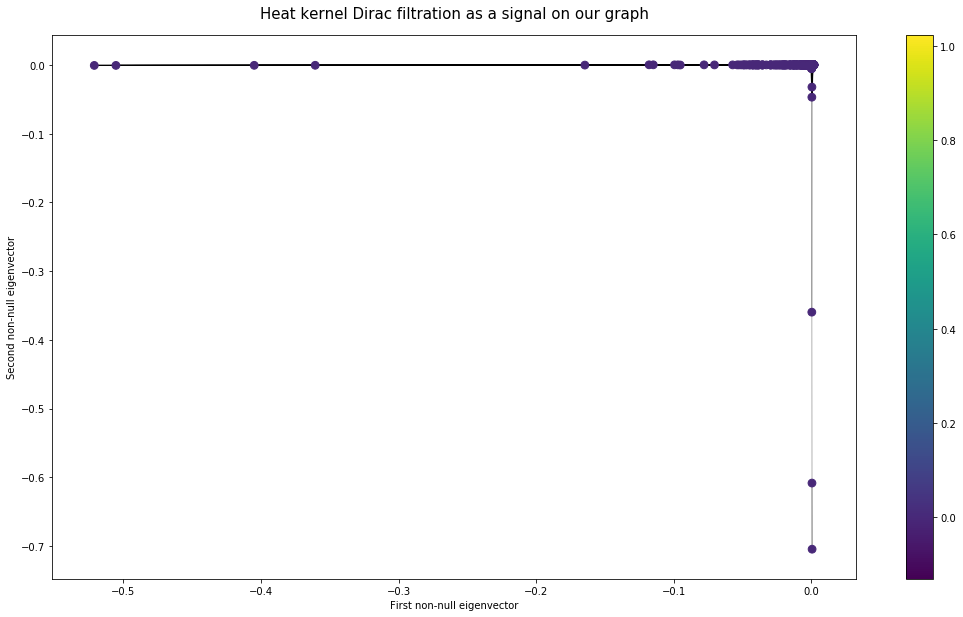

In [348]:
plt.figure(figsize = (18,10))
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=heat_filtered_dirac)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Heat kernel Dirac filtration as a signal on our graph", y=1.02, fontsize=15)
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes)
plt.show()

/home/pol/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


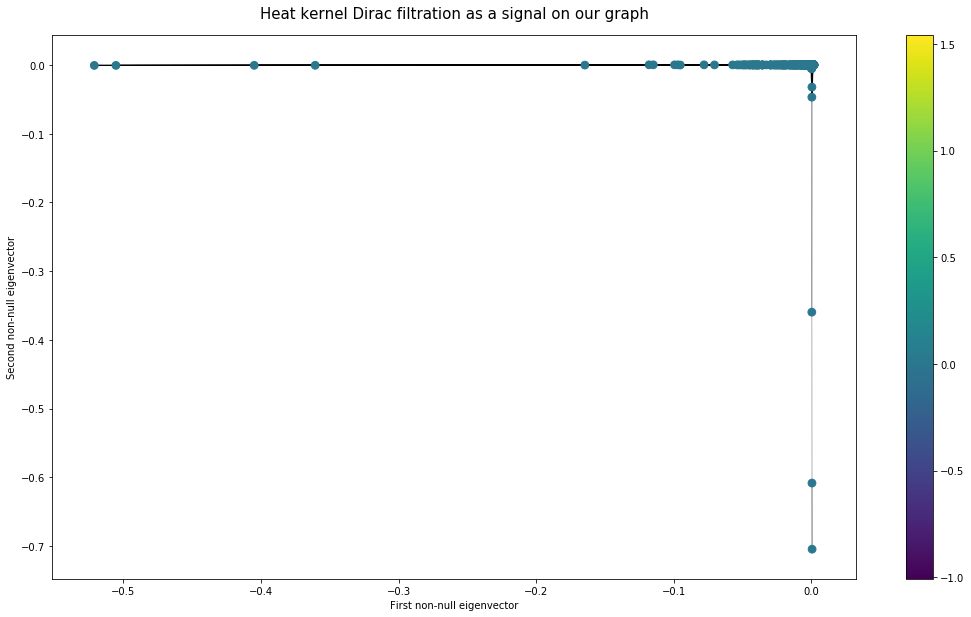

In [349]:
plt.figure(figsize = (18,10))
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=inverse_filtered_dirac)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Heat kernel Dirac filtration as a signal on our graph", y=1.02, fontsize=15)
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes)
plt.show()

/home/pol/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


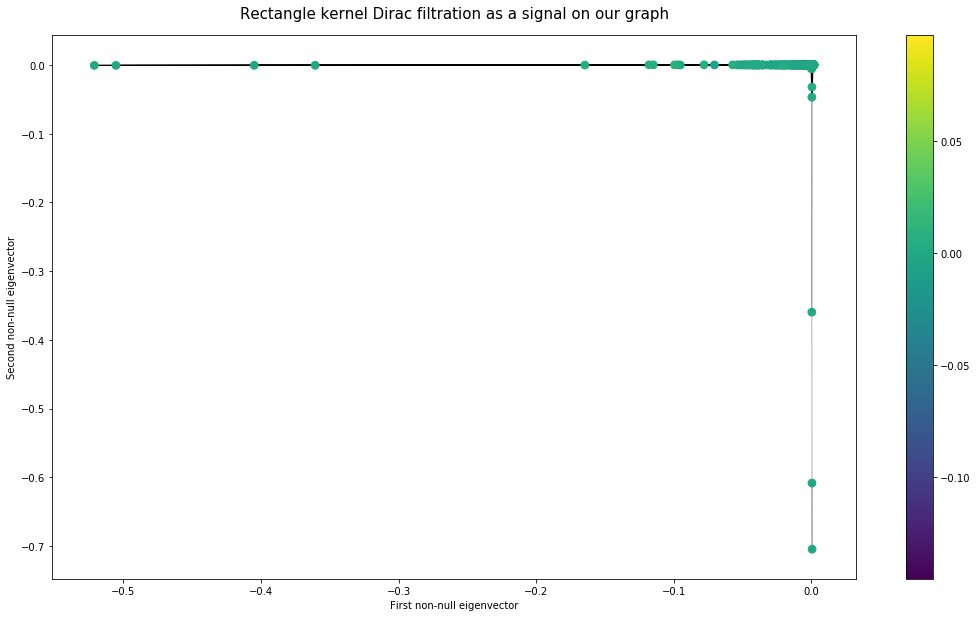

In [350]:
plt.figure(figsize = (18,10))
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=rectangle_filtered_dirac)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Rectangle kernel Dirac filtration as a signal on our graph", y=1.02, fontsize=15)
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes)
plt.show()


Comment on the "diffusion" of the Diracs induced by the filters. What does it say about the "communication" of information across your network? Relate that to the network connectivity measures that you analyzed during the previous milestones.

**Your answer here.**

For the three versions of filtered versions of the Diracs we observe at least some kind of diffusion. However, as we expected, we cannot deduce much information about such diffusion. 

## 3 - De-noising

In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.

### Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [433]:
labels_variance = np.var(label_signal)
noise_variance = labels_variance / 1.5
noisy_measurements = label_signal + abs(noise_variance * np.random.randn(n_nodes))

### Question 10

In the denoising setting, a common graph signal processing assumption is that the signal $z$ that we want to recover is "smooth", in the sense that $\|\nabla_G z\|_2 = \sqrt{z^{\top} L z}$ is small, while remaining "close" to the measurements that we start with. This leads to denoising by solving the following optimization problem:

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

where $y \in \mathbb{R}^{N}$ is the vector of noisy measurements.

Derive the close form solution to this problem giving $z^\star$ as a function of $y$, $\gamma$ and $L$. Does this solution correspond to any graph filtering operation that you know?

**Your answer here.**

We have $(z-y)^T(z-y)+\gamma z^{\top}Lz$

And when expanding it we get $(z^{\top}z-z^{\top}y-y^{\top}z+y^{\top}y)+\gamma z^{\top}Lz$

Now we derive w.r.t z to obtain $(2z-2y)^{\top}+(\gamma Lz)^{\top}+\gamma z^{\top}L^{\top}=(z-y)^{\top}+\gamma z^{\top}L^{\top}=z-y+\gamma Lz=0$ 

And finally we isolate z: $z^\star = (I+\gamma L)^{-1}\cdot y$

It looks like the inverse kernel.

### Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

In [444]:
z_heat_denoised = graph_filter(noisy_measurements, heat_kernel, tau=-0.1)
z_inv_denoised = graph_filter(noisy_measurements, inverse_kernel, tau=2)
z_rect_denoised = graph_filter(noisy_measurements, rectangle_kernel, l_min=0, l_max=0.1)

###### SOUCIS

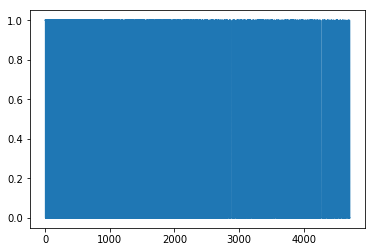

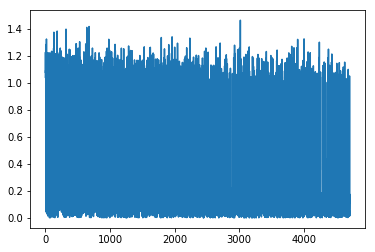

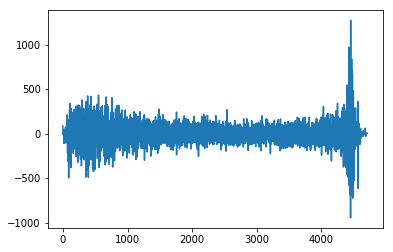

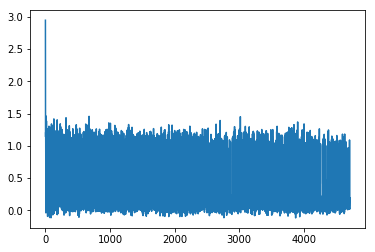

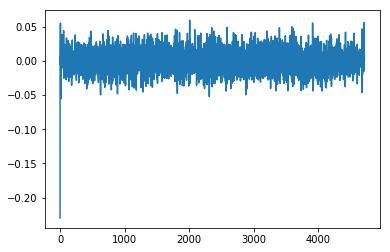

In [445]:
plt.plot(label_signal)
plt.show()
plt.plot(noisy_measurements)
plt.show()

plt.plot(z_inv_denoised)
plt.show()
plt.plot(z_heat_denoised)
plt.show()

plt.plot(z_rect_denoised)
plt.show()


In [395]:
z_heat_denoised.max()

1.4248056885749896

In [396]:
z_rect_denoised.max()

0.94028799295655

Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

/home/pol/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


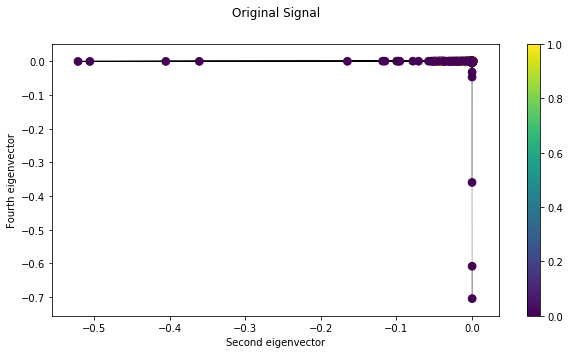

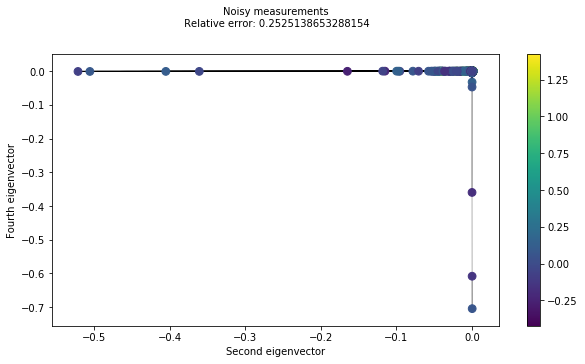

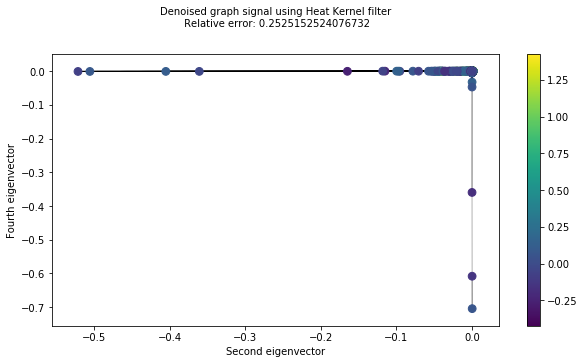

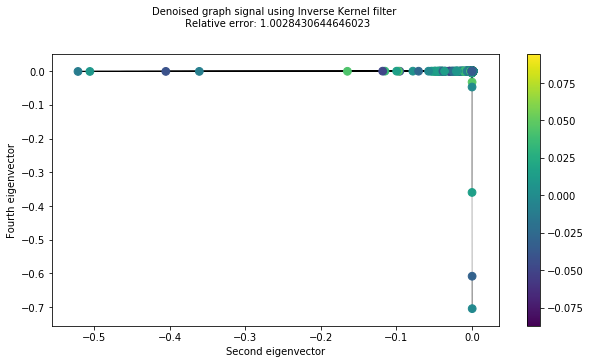

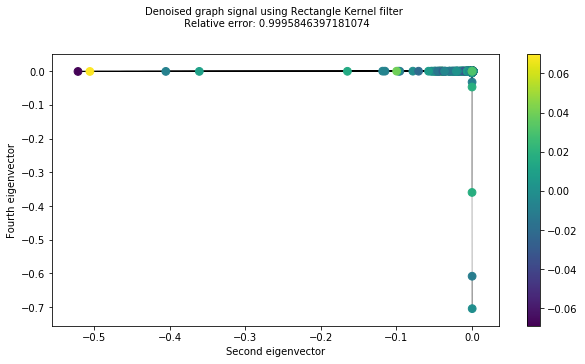

In [423]:
plt.figure(figsize = (10,5))
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=label_signal)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Original Signal" , y=1.08, fontsize=15)
plt.xlabel("Second eigenvector")
plt.ylabel("Fourth eigenvector")
plt.colorbar(nodes)
plt.show()

plt.figure(figsize = (10,5))
rel_err = np.linalg.norm(label_signal - noisy_measurements) / np.linalg.norm(label_signal)
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=noisy_measurements)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Noisy measurements\n Relative error: {}".format(rel_err), y=1.08, fontsize=15)
plt.xlabel("Second eigenvector")
plt.ylabel("Fourth eigenvector")
plt.colorbar(nodes)
plt.show()


plt.figure(figsize = (10,5))
rel_err = np.linalg.norm(label_signal - z_heat_denoised) / np.linalg.norm(label_signal)
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=z_heat_denoised)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Denoised graph signal using Heat Kernel filter\n Relative error: {}".format(rel_err), y=1.08, fontsize=15)
plt.xlabel("Second eigenvector")
plt.ylabel("Fourth eigenvector")
plt.colorbar(nodes)
plt.show()

plt.figure(figsize = (10,5))
rel_err = np.linalg.norm(label_signal - z_inv_denoised) / np.linalg.norm(label_signal)
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=z_inv_denoised)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Denoised graph signal using Inverse Kernel filter \n Relative error: {}".format(rel_err), y=1.08, fontsize=15)
plt.xlabel("Second eigenvector")
plt.ylabel("Fourth eigenvector")
plt.colorbar(nodes)
plt.show()

plt.figure(figsize = (10,5))
rel_err = np.linalg.norm(label_signal - z_rect_denoised) / np.linalg.norm(label_signal)
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=z_rect_denoised)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Denoised graph signal using Rectangle Kernel filter \n Relative error: {}".format(rel_err), y=1.08, fontsize=15)
plt.xlabel("Second eigenvector")
plt.ylabel("Fourth eigenvector")
plt.colorbar(nodes)
plt.show()

Finally, overlay on the same plot the GFT of all five signals above.

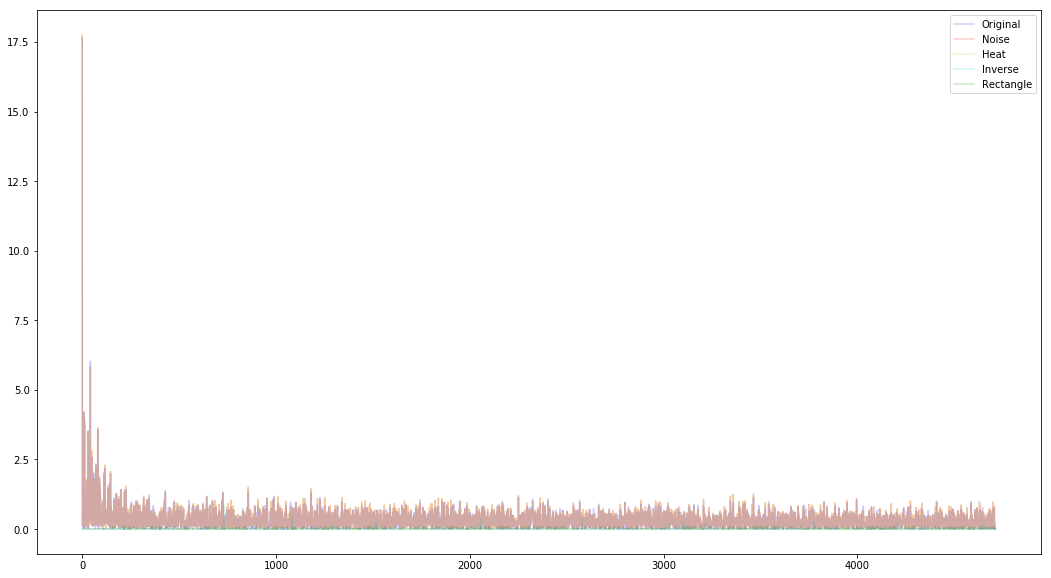

In [420]:
GFT_label = abs(GFT(label_signal))
GFT_noise = abs(GFT(noisy_measurements))
GFT_denoised_heat = abs(GFT(z_heat_denoised))
GFT_denoised_inv = abs(GFT(z_inv_denoised))
GFT_denoised_rect = abs(GFT(z_rect_denoised))

fig, ax = plt.subplots(figsize = (18,10))
ax.plot(GFT_label, 'b-', alpha=0.2, label = 'Original')
ax.plot(GFT_noise,'r-', alpha=0.2, label = 'Noise')
ax.plot(GFT_denoised_heat,'y-', alpha=0.2, label = 'Heat')
ax.plot(GFT_denoised_inv,'c-', alpha=0.2, label = 'Inverse')
ax.plot(GFT_denoised_rect,'g-', alpha=0.2, label = 'Rectangle')
ax.legend()
plt.show()


# À répondre

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

**Your answer here.**

As we can see, the heat kernel is the one that better filters our noisy measurements. The relative error is the smallest and its GFT is very similar to the label's signal one.

For filtering approaches, the underlying assumption is that the signal on which we operate is smooth. However, this is not that case for our label signal, which is a binary signal.

## 4 - Transductive learning

It is often the case in large networks that we can only afford to query properties/labels on a small subset of nodes. Nonetheless, if the underlying labels signal is "regular" enough, we might still be able to recover a good approximation of it by solving an offline variational problem, with constraints on the values of the measured nodes. 

In this section, we will be interested in solving such transductive learning problems by minimizing a (semi-) p-norm of the graph gradient applied to the signal of interest:

$$
\text{arg} \, \underset{z|_S = y}{\min} \|\nabla_G z\|_p^p,
$$

where $S$ is the set of measured nodes.

In English, we can say that we are looking for solutions with small "aggregated local variations", as measured by $\|\nabla_G z\|_p^p = \sum_{i=1}^{n} \sum_{j=1}^{n} \left( \sqrt{W_{ij}} |z[i] - z[j]| \right)^p,$ while satisfying the measurement constraints $z[i] = y[i]$ for $i \in S.$

We will work with two cases, according to the choices $p=1$ or $p=2.$ For $p=1,$ the problem is known as "interpolation by graph total-variation minimization," whereas for $p=2$ it is sometimes called "interpolation by Tikhonov regularization".

In order to solve these variational problems with the black-box solver provided to you, you will use the [pyunlocbox](https://pyunlocbox.readthedocs.io). This toolbox implements iterative solvers based on so-called ["proximal-splitting"](https://en.wikipedia.org/wiki/Proximal_gradient_method) methods.

### Question 13

Throughout this section, we will consider only a binarized version of your label signal. If your variable `labels` currently has values other than $\{-1, 1\},$ threshold them so that those are the only values taken in this vector. This can be done for example by choosing a number $t \in \mathbb{R}$ and then setting $\text{labels_bin}[i] = 1$ if $\text{labels}[i] \geq t$ and $\text{labels_bin}[i] = 0$ otherwise.

In [19]:
labels_bin = label_signal.copy()
labels_bin[np.where(label_signal == 0)] = -1

Now, subsample this binarized label signal by $70\%$ by choosing, uniformly at random, $30\%$ of the nodes whose labels we will keep.

You will do this by computing a "measurement mask" vector `w` with `1.0`'s at the measured coordinates, and $0.0$'s otherwise.

In [20]:
mn_ratio = 0.3
m = int(mn_ratio * n_nodes)  # Number of measurements.

w = np.array([0] * (n_nodes - m) + [1] * m)
np.random.shuffle(w)
w = w.astype(bool)

Plot the subsampled signal on the graph. _Hint:_ you might want to set to `numpy.nan` the values of the un-measured nodes for a cleaner plot.

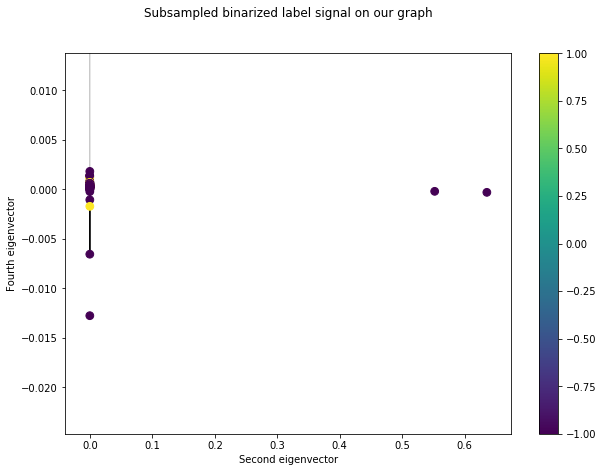

In [21]:
# Your code here.
subsampled_signal = labels_bin[w]

subsampled_nodes = list(np.where(w == True))[0]
subsampled_graph = graph.subgraph(subsampled_nodes)
mapping=dict(zip(subsampled_graph.nodes(),list(range(0, m))))
subsampled_graph = nx.relabel_nodes(subsampled_graph, mapping)
sub_coords = coords[w, :]

plt.figure(figsize=(10, 7))
subnodes = nx.draw_networkx_nodes(subsampled_graph, sub_coords, node_size=60, node_color=subsampled_signal)
nx.draw_networkx_edges(subsampled_graph, coords, alpha=0.3)
plt.title("Subsampled binarized label signal on our graph", y=1.08)
plt.xlabel("Second eigenvector")
plt.ylabel("Fourth eigenvector")
plt.colorbar(subnodes)
plt.show()

### Interlude

For the solution of the variational problems you can use the following function as a "black-box". 

You will just need to provide a `gradient` matrix (which you should already have from Section 0), and an orthogonal projection operator `P` onto the span of the measured coordinates (made precise in the next question).

In [22]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

### Question 14

During the iterations of the algorithm used for solving the variational problem, we have to make sure that the labels at the measured nodes stay the same. We will do this by means of an operator `P` which, given a vector $a \in \mathbb{R}^{N},$ returns another vector $b \in \mathbb{R}^{N}$ satisfying $b[i] = \text{labels_bin}[i]$ for every node $i$ in the set $S$ of known labels, and $b[i] = a[i]$ otherwise. Write in the cell below the function for this orthogonal projection operator `P`.

_Hint:_ remember you have already computed the mask `w`.

In [23]:
def P(a):
    b = a.copy()
    # The set of known labels is the set of subsampled labels that is described by the mask w
    b[w] = labels_bin[w]
    return b

### Question 15

Solve the variational problems for $p = 1$ and $p = 2$. Record the solution for the $1-$norm minimization under `sol_1norm_min` and the one for $2-$norm minimization under `sol_2norm_min`.

Compute also binarized versions of these solutions by thresholding the values with respect to $0$, that is, non-negative values become `1.0`, while negative values become `-1.0`. Store those binarized versions under `sol_1norm_bin` and `sol_2norm_bin`, respectively.

Since x0 was not initialized we initialized it to random. 

In [24]:
x0 = np.random.randn(n_nodes)

sol_1norm_min = graph_pnorm_interpolation(gradient, P, x0=x0, p=1)

sol_2norm_min = graph_pnorm_interpolation(gradient, P, x0=x0, p=2)

threshold = 0

sol_1norm_bin = [1 if i>threshold else -1 for i in sol_1norm_min]

sol_2norm_bin = [1 if i>threshold else -1 for i in sol_2norm_min]

Solution found after 101 iterations:
    objective function f(sol) = 3.307924e+05
    stopping criterion: RTOL
Solution found after 200 iterations:
    objective function f(sol) = 5.015110e+05
    stopping criterion: MAXIT


Plot, on your graph, the original `labels_bin` signal, as well as the solutions to the variational problems (both binarized and otherwise). Indicate on each plot the value of the relative error $\text{rel-err} = \frac{\|\text{labels_bin} - z\|_2}{\|\text{labels_bin}\|_2}$, where $z$ is the signal in the corresponding plot.

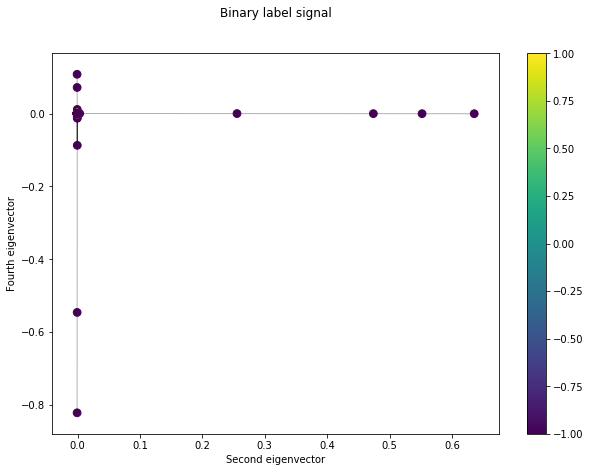

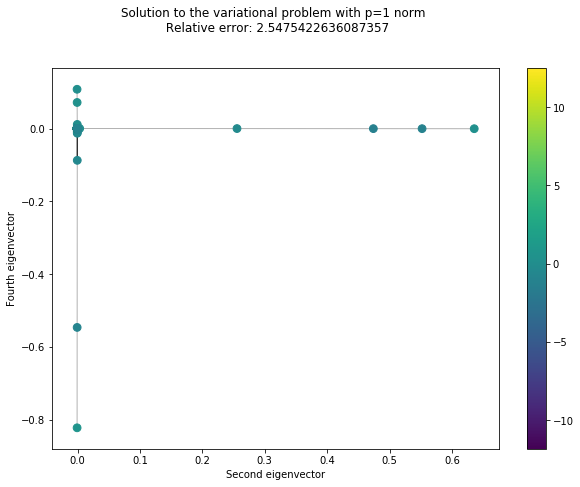

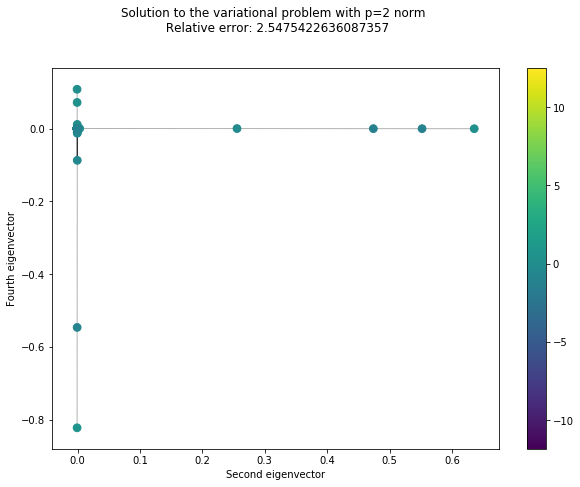

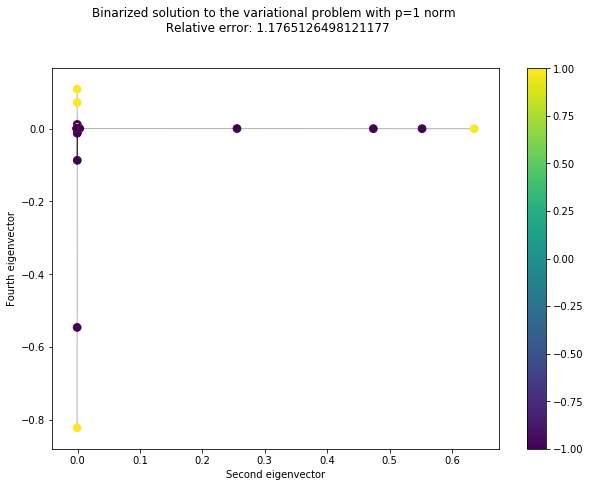

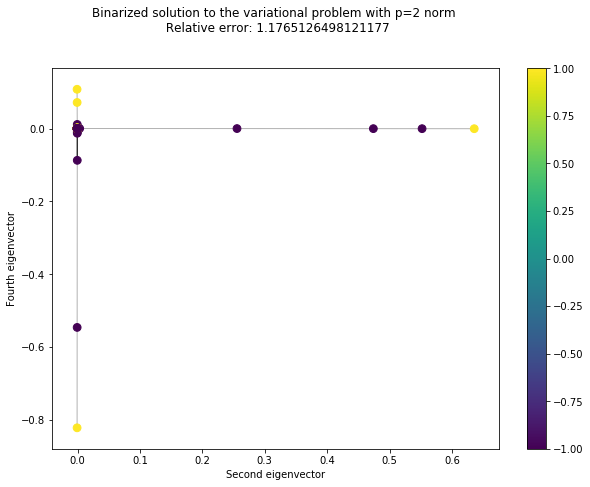

In [39]:
plt.figure(figsize = (10,7))
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=labels_bin)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Binary label signal", y=1.08)
plt.xlabel("Second eigenvector")
plt.ylabel("Fourth eigenvector")
plt.colorbar(nodes)
plt.show()

plt.figure(figsize = (10,7))
rel_err = np.linalg.norm(labels_bin - sol_1norm_min) / np.linalg.norm(labels_bin)
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=sol_1norm_min)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Solution to the variational problem with p=1 norm \n Relative error: {}".format(rel_err), y=1.08)
plt.xlabel("Second eigenvector")
plt.ylabel("Fourth eigenvector")
plt.colorbar(nodes)
plt.show()

plt.figure(figsize = (10,7))
rel_err = np.linalg.norm(labels_bin - sol_2norm_min) / np.linalg.norm(labels_bin)
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=sol_2norm_min)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Solution to the variational problem with p=2 norm \n Relative error: {}".format(rel_err), y=1.08)
plt.xlabel("Second eigenvector")
plt.ylabel("Fourth eigenvector")
plt.colorbar(nodes)
plt.show()

plt.figure(figsize = (10,7))
rel_err = np.linalg.norm(labels_bin - sol_1norm_bin) / np.linalg.norm(labels_bin)
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=sol_1norm_bin)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Binarized solution to the variational problem with p=1 norm \n Relative error: {}".format(rel_err), y=1.08)
plt.xlabel("Second eigenvector")
plt.ylabel("Fourth eigenvector")
plt.colorbar(nodes)
plt.show()

plt.figure(figsize = (10,7))
rel_err = np.linalg.norm(labels_bin - sol_2norm_bin) / np.linalg.norm(labels_bin)
nodes = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=sol_2norm_bin)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Binarized solution to the variational problem with p=2 norm \n Relative error: {}".format(rel_err), y=1.08)
plt.xlabel("Second eigenvector")
plt.ylabel("Fourth eigenvector")
plt.colorbar(nodes)
plt.show()

### Question 16

Now that you have got a feeling for the sort of solutions that the transductive learning problems studied can give, we will see what is the effect of the number of measurements on the accuracy of both $p-$norm minimization problems.

Towards this goal, you will write a `phase_transition()` function. This function will basically go over all the procedures that you have implemented in this section, but for varying numbers of measurements and thresholding values. It will also compute the relative error, $\text{rel-err},$ of the solutions and average them over a number of trials.

The output of the `phase_transition()` function has to be a matrix with `len(mn_ratios)` columns and `len(thresholds)` rows. Each pixel $(i,j)$ in the output matrix has to contain the average, over `n_trials` trials, of the relative error $\text{rel-err}$ in the binarized (with threshold `thresholds[i]`) solution given by `graph_pnorm_interpolation()` from observing an `mn_ratios[j]` fraction of nodes. The randomness comes from a different choice of mask `w` at each trial, hence the averaging.

The interest of this phase transition matrix is to assess what level of recovery error one could expect for a certain fraction of measurements and a certain threshold level.

In [25]:
def phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p):

    pt_matrix = np.zeros((len(thresholds), len(mn_ratios)))
    for (i, thresh) in enumerate(thresholds):
        for (j, ratio) in enumerate(mn_ratios):
            err = np.zeros((n_trials, 1))
            for t in range(n_trials):
                # Create sample mask.
                m = int(ratio * n_nodes)  # Number of measurements.

                w = np.array([0] * (n_nodes - m) + [1] * m)
                np.random.shuffle(w)
                w = w.astype(bool)

                # Solve p-norm interpolation.
                x0 = np.random.randn(n_nodes)
                sol = graph_pnorm_interpolation(gradient, P, x0=x0, p=p)
                err[t] = np.linalg.norm(labels_bin - sol) / np.linalg.norm(labels_bin)

            # Aggregate.
            pt_matrix[i,j] = np.mean(err)
    
    return pt_matrix

### Question 17

Pick 5 "m/n" ratios in $(0, 1)$ and 5 threshold levels in $(-1, 1)$ and run the `phase_transition()` function with `n_trials` = 20, for both $p = 1$ and $p = 2$.

We previously saw that our values were around 0 most of the time. This is why our thresholds are focused around 0.

In [26]:
mn_ratios = [0.15, 0.3, 0.45, 0.6, 0.75]

thresholds = [-0.4, -0.2, 0, 0.2, 0.4]

pt_matrix_1norm = phase_transition(mn_ratios, thresholds, 20, labels_bin, p=1)

pt_matrix_2norm = phase_transition(mn_ratios, thresholds, 20, labels_bin, p=2)

Solution found after 100 iterations:
    objective function f(sol) = 3.294465e+05
    stopping criterion: RTOL
Solution found after 13 iterations:
    objective function f(sol) = 6.507294e+04
    stopping criterion: RTOL
Solution found after 13 iterations:
    objective function f(sol) = 6.575817e+04
    stopping criterion: RTOL
Solution found after 13 iterations:
    objective function f(sol) = 6.512350e+04
    stopping criterion: RTOL
Solution found after 102 iterations:
    objective function f(sol) = 3.297545e+05
    stopping criterion: RTOL
Solution found after 101 iterations:
    objective function f(sol) = 3.402542e+05
    stopping criterion: RTOL
Solution found after 13 iterations:
    objective function f(sol) = 6.578686e+04
    stopping criterion: RTOL
Solution found after 13 iterations:
    objective function f(sol) = 6.504624e+04
    stopping criterion: RTOL
Solution found after 100 iterations:
    objective function f(sol) = 3.441242e+05
    stopping criterion: RTOL
Soluti

Plot both phase transition matrices as images with a colorbar. Make sure to properly name the axes and title the images. 

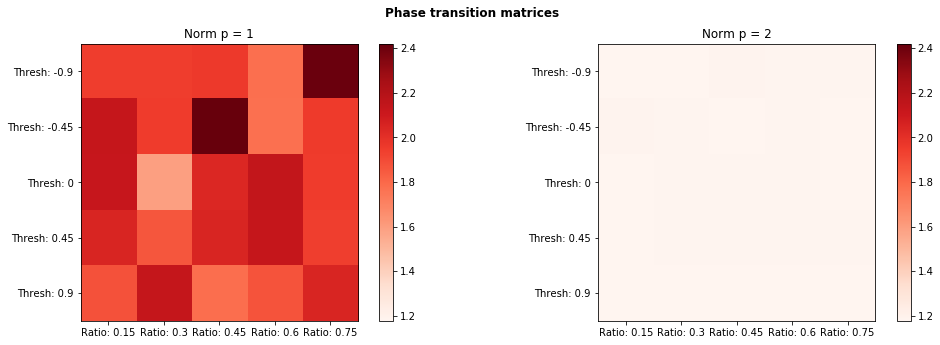

In [35]:
# Your code here.
names_x = ['Ratio: '+str(0.15), 'Ratio: '+str(0.3), 'Ratio: '+str(0.45), 'Ratio: '+str(0.6), 'Ratio: '+str(0.75)]
names_y = ['Thresh: '+str(-0.9), 'Thresh: '+str(-0.45), 'Thresh: '+str(0), 'Thresh: '+str(0.45), 'Thresh: '+str(0.9)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5.1))
fig.suptitle("Phase transition matrices",fontweight="bold")

min_data = min(np.min(pt_matrix_1norm), np.min(pt_matrix_2norm))
max_data = max(np.max(pt_matrix_1norm), np.max(pt_matrix_2norm))

im1 = ax1.imshow(pt_matrix_1norm, vmin=min_data, vmax=max_data, cmap='Reds')

# We want to show all ticks...
ax1.set_xticks(np.arange(len(names_x)))
ax1.set_yticks(np.arange(len(names_y)))
# ... and label them with the respective list entries
ax1.set_xticklabels(names_x)
ax1.set_yticklabels(names_y)
ax1.set_title('Norm p = 1')

im2 = ax2.imshow(pt_matrix_2norm, vmin=min_data, vmax=max_data, cmap='Reds')

# We want to show all ticks...
ax2.set_xticks(np.arange(len(names_x)))
ax2.set_yticks(np.arange(len(names_y)))
# ... and label them with the respective list entries
ax2.set_xticklabels(names_x)
ax2.set_yticklabels(names_y)
ax2.set_title('Norm p = 2')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

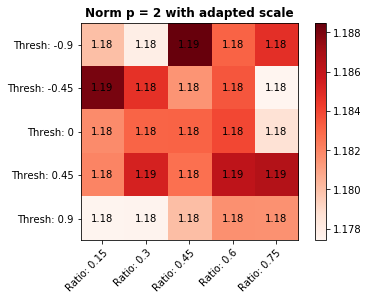

In [39]:
fig, ax = plt.subplots()

min_data = np.min(pt_matrix_2norm)
max_data = np.max(pt_matrix_2norm)

im = ax.imshow(pt_matrix_2norm, vmin=min_data, vmax=max_data, cmap='Reds')

# We want to show all ticks...
ax.set_xticks(np.arange(len(names_x)))
ax.set_yticks(np.arange(len(names_y)))
# ... and label them with the respective list entries
ax.set_xticklabels(names_x)
ax.set_yticklabels(names_y)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(names_y)):
    for j in range(len(names_x)):
        string = "{0:.2f}".format(pt_matrix_2norm[i, j])
        text = ax.text(j, i, string,
                       ha="center", va="center", color="black")

ax.set_title('Norm p = 2 with adapted scale', fontweight='bold')
fig.colorbar(im)
plt.show()

### Question 18

Do the phase transition plots above provide any justification for choosing one $p-$norm interpolation over the other? Why?

**Your answer here.**

We purposely plotted both matrix using the same scale. As we can see, the p=1 matrix systematically has much higher relative errors than the p=2 matrix. The p=2 matrix has the lowest error of both scales combined throughout the whole matrix. Indeed, the relative error of the p=2 matrix is always twice as low as the highest error in the p=1 matrix. 

Moreover, when using the p=2 norm, we can observe that the relative error doesn't change much when the parameters such as threshold and subsampling ratio) change, which indicates a more stable approach. 

We can conclude that the method that yields the least error between the predicted and the actual labels is using the p=2 norm in the optimization problem.

The best parameters when using this norm seem to be: either an extreme threshold ($+/- 0.9$) and a low subsampling ratio ($0.15/0.3$) or a high ratio ($0.75$) and a medium threshold ($-0.45 / 0$)